In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score
from unidecode import unidecode
import re
from geopy.geocoders import Nominatim
from time import sleep

In [54]:
test_df=pd.read_csv("apartment_for_rent_test.csv", encoding='utf-8')

In [69]:
def clean_apartment_data_train(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    if 'Price' in df.columns:
        df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    
    if 'Currency' in df.columns:
        df['Currency'] = df['Currency'].astype(str)
        conversion_rates = {'USD': 400, 'EUR': 430, 'RUB': 4.5}
        for currency, rate in conversion_rates.items():
            mask = df['Currency'].str.upper() == currency
            df.loc[mask, 'Price'] = df.loc[mask, 'Price'] * rate
        df['Currency'] = 'AMD'
    
    if 'Duration' in df.columns:
        df['Duration'] = df['Duration'].astype(str)
        daily_mask = df['Duration'].str.lower().str.contains('daily')
        df.loc[daily_mask, 'Price'] = df.loc[daily_mask, 'Price'] * 30
        df.loc[daily_mask, 'Duration'] = 'monthly'

    # Address cleaning
    if 'Address' in df.columns:
        def clean_address(address):
            if pd.isnull(address):
                return None
            address = ''.join(c for c in address if c.isprintable())
            address = re.sub(r'[^\w\s,.-]', '', address)
            address = unidecode(address)
            # Example mappings
            address_map = {
                'Yerevan???': 'Yerevan',
                'Arabkir###': 'Arabkir',
                # ... other mappings ...
            }
            return address_map.get(address, address).strip()
        
        df['Address'] = df['Address'].apply(clean_address)

    # Drop rows with missing price
    df = df.dropna(subset=['Price'])

    # Numeric columns
    numeric_cols = ['Age', 'Floor_area', 'Number_of_rooms', 'Number_of_bathrooms',
                    'Ceiling_height', 'Floor', 'Floors_in_the_building']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median())
    
    # Categorical columns
    categorical_cols = ['Gender', 'Construction_type', 'Currency', 'Duration',
                        'amenities', 'appliances', 'parking', 'Address', 'Furniture',
                        'Renovation', 'Balcony']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)

    # Binary columns
    binary_cols = ['New_construction', 'Elevator', 'Children_are_welcome', 
                   'Pets_allowed', 'Utility_payments']
    for col in binary_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
    
    return df
    
test_cleaned = clean_apartment_data_train(test_df)
test_cleaned.head()
test_cleaned.to_csv("cleaned_test_data.csv")

In [56]:
# Top discrete contributors
def identify_top_discrete_contributors(df):
    df = df.copy()
    discrete_vars = ['Balcony', 'Furniture', 'Renovation', 'Gender', 'Construction_type']
    means = {}
    for var in discrete_vars:
        if var in df.columns:
            means[var] = df.groupby(var)['Price'].mean().sort_values(ascending=False)
    return means

# Correlation matrix
def calculate_correlations(df):
    df = df.copy()
    df['Duration_Binary'] = df['Duration'].astype(str).apply(lambda x: 1 if 'month' in x.lower() else 0)
    subset = df[['Number_of_rooms', 'Price', 'Duration_Binary']].dropna()
    return subset.corr()

# Regression analysis
def regression_analysis(df):
    df = df.copy()

    # Extract region from Address: last word
    df['Region'] = df['Address'].astype(str).apply(lambda x: x.split()[-1] if isinstance(x, str) and len(x.split()) > 0 else 'Unknown')
    
    # Encode region + other categorical features
    df['Region_Code'] = df['Region'].astype('category').cat.codes
    df['Construction_type_code'] = df['Construction_type'].astype('category').cat.codes
    df['Furniture_code'] = df['Furniture'].astype('category').cat.codes

    # Define features
    features = ['Region_Code', 'Number_of_rooms', 'Construction_type_code', 'Furniture_code']
    X = df[features].fillna(0)
    y = df['Price']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Output
    coeff_df = pd.DataFrame(model.coef_, index=features, columns=['Coefficient'])
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return coeff_df, mse, r2

# Cleaning function
def clean_apartment_data(df):
    df = df.copy()
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    if 'Price' in df.columns:
        df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
        df = df.dropna(subset=['Price'])
    
    numeric_cols = ['Number_of_rooms', 'Floor_area']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median())

    df['Duration'] = df['Duration'].astype(str)
    return df

# Example usage (assume test_df already loaded)
test_cleaned = clean_apartment_data(test_df)
top_discrete_means_test = identify_top_discrete_contributors(test_cleaned)
correlation_matrix_test = calculate_correlations(test_cleaned)
coefficients_test, mse_test, r2_test = regression_analysis(test_cleaned)

# Print results
print("\nTop Discrete Means:")
for var, means in top_discrete_means_test.items():
    print(f"\n{var}:\n{means}")

print("\nCorrelation Matrix:\n", correlation_matrix_test)
print("\nCoefficients:\n", coefficients_test)
print("\nMSE Test =", mse_test)
print("\nR² =", r2_test)


Top Discrete Means:

Balcony:
Balcony
Not available         208440.756230
Closed balcony        149886.655377
Multiple balconies    108708.412131
Open balcony           97088.854364
Name: Price, dtype: float64

Furniture:
Furniture
Available            171000.079494
By agreement         122361.971831
Not available        117857.746479
Partial Furniture    104814.814815
Name: Price, dtype: float64

Renovation:
Renovation
Designer Renovation    164766.886953
Partial Renovation     157559.064327
Cosmetic Renovation    152866.956522
Old Renovation         131739.361702
Major Renovation       122986.586479
Euro Renovation        114538.504748
No Renovation           85346.153846
Name: Price, dtype: float64

Gender:
Gender
Male      156260.846439
Female    115633.680965
Name: Price, dtype: float64

Construction_type:
Construction_type
Cassette    215140.000000
Stone       188507.208216
Panels      148866.587554
Bricks       84559.677419
Monolith     83410.530861
Wooden       11000.000000
Na

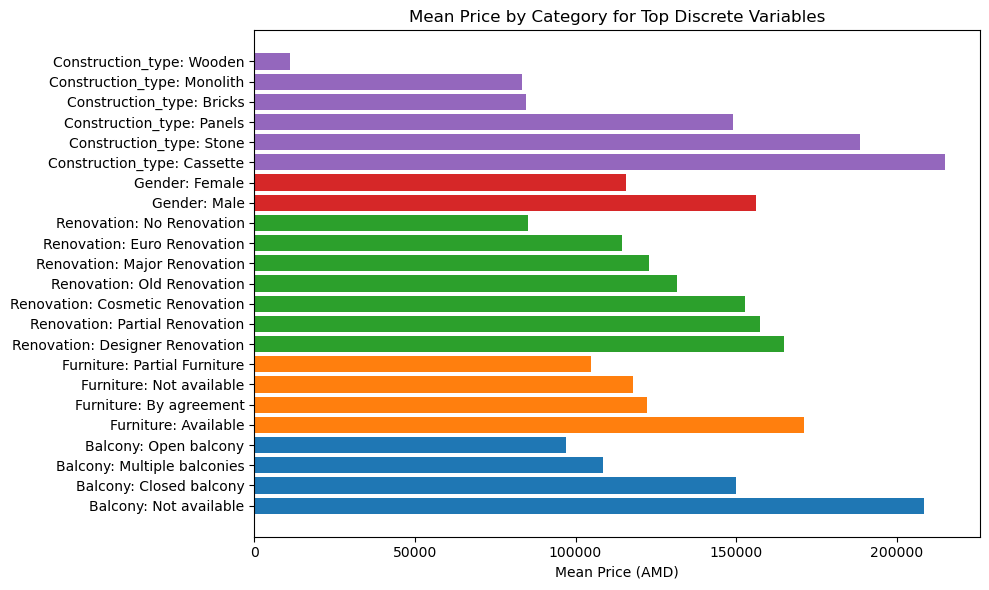

In [57]:
# Generate Task 1A visual for Top 3 Discrete Variables vs Average Rent Price
# Combine the data into a DataFrame for plotting
plot_data = []
for var, series in top_discrete_means_test.items():
    for category, price in series.items():
        plot_data.append((var, category, price))

plot_df = pd.DataFrame(plot_data, columns=['Variable', 'Category', 'MeanPrice'])

# Plot
plt.figure(figsize=(10, 6))

# Plot bars grouped by variable
for var in plot_df['Variable'].unique():
    subset = plot_df[plot_df['Variable'] == var]
    plt.barh(
        [f"{var}: {cat}" for cat in subset['Category']],
        subset['MeanPrice']
    )

plt.xlabel('Mean Price (AMD)')
plt.title('Mean Price by Category for Top Discrete Variables')
plt.tight_layout()

# Save or display the plot
plt.savefig('Top_Discrete_Average_Price_Means.png')
plt.show()

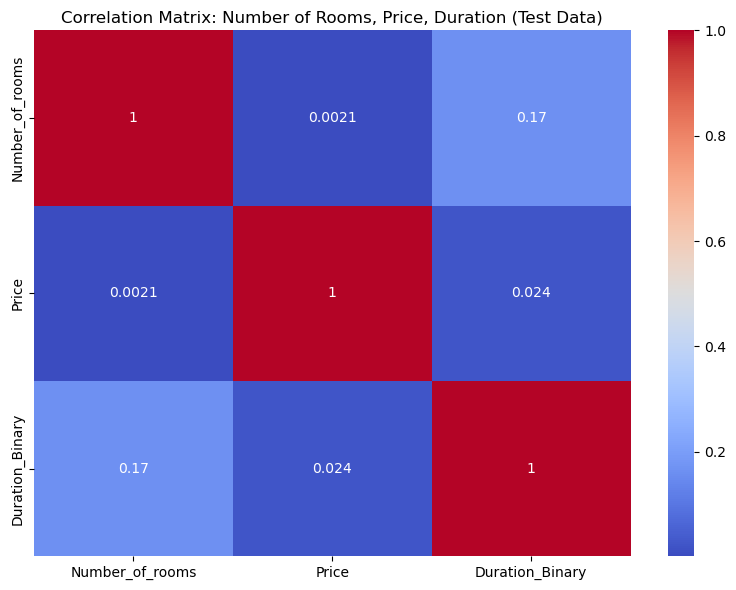

In [58]:
# Generate Task 1B visual for Correlation Matrix heatmap for rooms, price and Duration.

# Compute correlation matrix
test_cleaned['Duration'] = test_cleaned['Duration'].apply(lambda x: 1 if 'month' in str(x).lower() else 0)
correlation_matrix = test_cleaned[['Number_of_rooms', 'Price', 'Duration']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_test, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Number of Rooms, Price, Duration (Test Data)')
plt.tight_layout()
plt.savefig('Correlation_Matrix_Test.png')
plt.show()

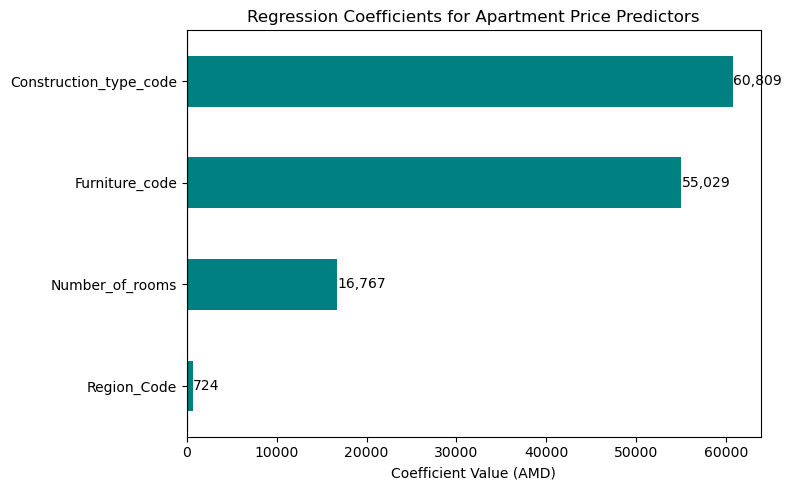

In [59]:
import matplotlib.pyplot as plt

# Assuming you've run:
# coefficients_test, mse_test, r2_test = regression_analysis(test_cleaned)

# Sort and color
sorted_coef = coefficients_test['Coefficient'].sort_values()
colors = sorted_coef.apply(lambda x: 'teal' if x >= 0 else 'salmon')

# Plot
plt.figure(figsize=(8, 5))
ax = sorted_coef.plot(kind='barh', color=colors)

# Add data labels
for i, value in enumerate(sorted_coef):
    ax.text(value, i, f'{value:,.0f}', va='center',
            ha='left' if value >= 0 else 'right',
            fontsize=10, color='black')

plt.xlabel('Coefficient Value (AMD)')
plt.title('Regression Coefficients for Apartment Price Predictors')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()

# Save the plot
plt.savefig('Regression_Coefficients.png')
plt.show()


In [73]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers, lower, upper

# Detect outliers for Price
price_outliers, price_lower, price_upper = detect_outliers_iqr(df, 'Price')

# Detect outliers for Number_of_rooms
rooms_outliers, rooms_lower, rooms_upper = detect_outliers_iqr(df, 'Number_of_rooms')

# Detect outliers for Floor_area
area_outliers, area_lower, area_upper = detect_outliers_iqr(df, 'Floor_area')

# Summary
print(f"Price outliers: {len(price_outliers)}")
print(f"Number_of_rooms outliers: {len(rooms_outliers)}")
print(f"Floor_area outliers: {len(area_outliers)}")

# Optionally: return outliers dataframes for inspection
(price_outliers.head(), rooms_outliers.head(), area_outliers.head())

outliers=detect_outliers_iqr(test_cleaned)

NameError: name 'df' is not defined